In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.utils import shuffle
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
## 이상치 제거
def outliers_iqr(data):
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    # 넘파이 값을 퍼센트로 표시해주는 함수
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)

    return np.where((data > upper_bound) | (data < lower_bound))

### OLS를 활용해 회귀분석

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
jasan_df = pd.read_csv('./data/자산총계_최종.csv', index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})
buchae_df = pd.read_csv('./data/부채총계_최종.csv', index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})
jabon_df = pd.read_csv('./data/자본총계_최종.csv', index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})
siga_df = pd.read_csv('./data/시가총액/시가총액_연평균.csv', index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})
LEV = pd.read_csv('./data/LEV.csv', index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})

In [5]:
LEV = pd.DataFrame()
for name in jasan_df['corp_name']:
    na_cnt =  jasan_df[jasan_df.corp_name == name].isnull().sum(axis=1).values[0]

    if na_cnt == 0:
        lev = buchae_df[buchae_df.corp_name == name].iloc[:, 4:].values / jasan_df[jasan_df.corp_name == name].iloc[:, 4:].values
        lev = pd.DataFrame(lev, columns = jasan_df.columns[4:])
    else:
        lev = buchae_df[buchae_df.corp_name == name].iloc[:, 4:-na_cnt].values / jasan_df[jasan_df.corp_name == name].iloc[:, 4:-na_cnt].values
        lev = pd.DataFrame(lev, columns = jasan_df.columns[4:-na_cnt])

    lev.insert(0, '종목명', name)
    LEV = pd.concat([LEV, lev])
LEV.reset_index(drop=True, inplace=True)

In [6]:
LEV_df = pd.DataFrame()
for i in LEV.columns[2:]:
    lev = LEV[['종목명', i]]
    lev.columns = ['종목명', 'LEV']
    lev['연도'] = i
    LEV_df = pd.concat([LEV_df, lev])

In [7]:
SIZE = np.log(jasan_df.iloc[:, 4:])
SIZE = pd.concat([jasan_df[['corp_name', 'stock_code']], SIZE], axis=1)
SIZE_df = pd.DataFrame()

for i in SIZE.columns[2:]:
    size = SIZE[['stock_code', 'corp_name', i]]
    size.columns = ['기업코드', '종목명', 'SIZE']
    size['연도'] = i
    SIZE_df = pd.concat([SIZE_df, size])

### 전처리

In [58]:
final_df = pd.read_csv('./data/최종데이터/최종데이터_ESG환산.csv', index_col=0)

In [59]:
final_df = final_df.replace("A+", 6).replace("A", 5).replace("B+", 4).replace("B", 3).replace("C", 2).replace("D", 1).replace("E", np.NaN)

In [60]:
LEV_df['연도'] = LEV_df['연도'].astype('int64')
SIZE_df['연도'] = SIZE_df['연도'].astype('int64')

In [61]:
LEV_df.head()

,종목명,LEV,연도
0,지역난방공사,0.702998,2020
1,아시아나IDT,0.364363,2020
2,현대약품,0.427684,2020
3,코스맥스,0.771329,2020
4,경인양행,0.547850,2020


In [62]:
final_df = pd.merge(final_df, LEV_df[['종목명', '연도', 'LEV']], on=['종목명', '연도'])
final_df = pd.merge(final_df, SIZE_df[['종목명', '연도', 'SIZE']], on=['종목명', '연도'])

In [63]:
final_df.dropna(axis=0, inplace=True)
final_df = final_df[final_df['누적수익률'] != 'np.NAN']
final_df['누적수익률'] = final_df['누적수익률'].astype('float')

In [64]:
final_df

,종목명,연도,누적수익률,종합등급,환경,사회,지배구조,ROA,ROE,tobinQ,코스피누적수익률,LEV,SIZE
1,AJ네트웍스,2016,-16.696604,3.0,2.0,3.0,3.0,0.820595,3.995265,0.756037,0.244437,0.794608,28.364022
2,AJ네트웍스,2017,-21.116001,3.0,3.0,3.0,3.0,0.877023,4.617270,0.719738,14.838077,0.810056,28.487236
3,AJ네트웍스,2018,-15.324073,3.0,2.0,3.0,3.0,1.447255,7.577926,0.574388,17.010852,0.809017,28.576925
4,AJ네트웍스,2019,-27.945367,3.0,1.0,3.0,3.0,2.336252,12.128881,0.651385,-8.843388,0.807381,28.220615
5,AJ네트웍스,2020,-37.503193,3.0,1.0,3.0,3.0,-0.208845,-1.151640,0.556895,-4.513591,0.818654,28.093604
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5740,후성,2016,92.884451,3.0,3.0,3.0,4.0,19.759910,38.586363,3.582117,0.244437,0.487904,26.462838
5741,후성,2017,132.717768,3.0,2.0,3.0,4.0,8.928117,13.509607,4.251250,14.838077,0.339128,26.479372
5742,후성,2018,59.411275,3.0,3.0,3.0,4.0,6.353841,11.426047,3.626249,17.010852,0.443916,26.813401
5743,후성,2019,-8.495724,3.0,3.0,2.0,3.0,0.038912,0.084715,3.073370,-8.843388,0.540669,26.994080


### 상관계수

In [65]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

<AxesSubplot:>

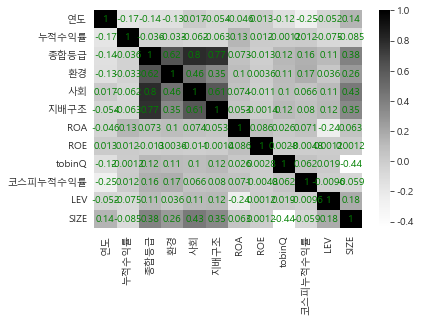

In [66]:
sns.heatmap(final_df.corr(), annot=True, annot_kws=dict(color='g'), cmap='Greys')


### 회귀분석

In [67]:
final_df.columns

Index(['종목명', '연도', '누적수익률', '종합등급', '환경', '사회', '지배구조', 'ROA', 'ROE',
       'tobinQ', '코스피누적수익률', 'LEV', 'SIZE'],
      dtype='object')

In [118]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [134]:
res = ols('ROA ~ 종합등급+환경+사회+지배구조+연도+LEV+SIZE+ROE+코스피누적수익률+누적수익률', data=final_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     54.74
Date:                Sun, 15 May 2022   Prob (F-statistic):          6.69e-105
Time:                        18:38:10   Log-Likelihood:                -17657.
No. Observations:                4648   AIC:                         3.534e+04
Df Residuals:                    4637   BIC:                         3.541e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    327.1299    129.788      2.520      0.0

In [70]:
final_df.columns

Index(['종목명', '연도', '누적수익률', '종합등급', '환경', '사회', '지배구조', 'ROA', 'ROE',
       'tobinQ', '코스피누적수익률', 'LEV', 'SIZE'],
      dtype='object')

In [139]:
res = ols('ROE ~ 환경+사회+지배구조+LEV+ROA+누적수익률', data=final_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.577
Date:                Sun, 15 May 2022   Prob (F-statistic):           6.22e-07
Time:                        18:39:42   Log-Likelihood:                -31508.
No. Observations:                4648   AIC:                         6.303e+04
Df Residuals:                    4641   BIC:                         6.308e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1550     16.440      0.192      0.8

In [144]:
res = ols('tobinQ ~ 환경+사회+지배구조+LEV+SIZE+누적수익률+코스피누적수익률', data=final_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 tobinQ   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     336.9
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        18:40:58   Log-Likelihood:                -60188.
No. Observations:                4648   AIC:                         1.204e+05
Df Residuals:                    4640   BIC:                         1.204e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.151e+05   2.25e+04     40.713      0.0

In [145]:
final_df.describe()

,연도,누적수익률,종합등급,환경,사회,지배구조,ROA,ROE,tobinQ,코스피누적수익률,LEV,SIZE
count,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4.648000e+03,4648.000000,4648.000000,4648.000000
mean,2016.021084,15.934108,3.144793,2.767212,3.291093,3.288511,2.155157,4.121703,9.405814e+03,3.769981,0.465258,27.019159
std,2.686309,70.863531,0.692042,0.931033,0.821640,0.735831,11.424236,213.647693,1.249672e+05,8.372362,0.210572,1.847200
min,2011.000000,-97.254766,1.000000,1.000000,1.000000,1.000000,-95.635348,-2818.284747,-6.131463e+01,-8.843388,0.024488,13.060203
25%,2014.000000,-23.425276,3.000000,2.000000,3.000000,3.000000,0.175863,0.419832,5.340093e-01,-1.211481,0.303779,26.030290
50%,2016.000000,-0.541971,3.000000,3.000000,3.000000,3.000000,2.419759,4.715228,8.545047e-01,2.619181,0.470445,26.891537
75%,2018.000000,33.759901,3.000000,3.000000,3.000000,4.000000,5.147215,9.179382,1.414875e+00,12.439058,0.614202,27.879688
max,2020.000000,812.227334,6.000000,6.000000,6.000000,6.000000,407.621431,13546.418464,3.053058e+06,17.010852,2.945354,33.566539


### 이상치 제거하기

In [146]:
final_df.reset_index(drop=True, inplace=True)

In [147]:
outlier_cols = ['ROA', 'ROE','tobinQ']
total_outliers = []
normal_index = []

for col in outlier_cols:
    outliers_index = outliers_iqr(final_df[col])[0]
    total_outliers.append(outliers_index)

total_outliers = [val for arr in total_outliers for val in arr]
print(len(total_outliers))

for i in final_df.index:
    if i not in total_outliers:
        normal_index.append(i)


1473


In [148]:
final_df_clean = final_df.loc[normal_index]
final_df_clean.describe()

,연도,누적수익률,종합등급,환경,사회,지배구조,ROA,ROE,tobinQ,코스피누적수익률,LEV,SIZE
count,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000
mean,2016.059714,12.223573,3.141043,2.780870,3.278573,3.289381,2.831842,4.910389,0.891440,3.754504,0.445936,27.200095
std,2.654308,54.593147,0.681884,0.921996,0.814031,0.724303,3.330064,5.981161,0.533320,8.383863,0.199001,1.495614
min,2011.000000,-97.254766,1.000000,1.000000,1.000000,1.000000,-7.020217,-12.693839,0.094004,-8.843388,0.024488,24.000482
25%,2014.000000,-21.747464,3.000000,2.000000,3.000000,3.000000,0.716239,1.480552,0.495927,-1.211481,0.291332,26.133101
50%,2016.000000,-0.427299,3.000000,3.000000,3.000000,3.000000,2.585740,4.934787,0.760332,2.619181,0.450099,26.955053
75%,2018.000000,30.631486,3.000000,3.000000,3.000000,4.000000,4.923599,8.671294,1.132947,12.439058,0.590914,27.929088
max,2020.000000,587.185343,6.000000,6.000000,6.000000,6.000000,12.594916,22.174749,2.731965,17.010852,2.945354,33.566539


### 회귀분석 (데이터 이상치 제거후)

In [158]:
res = ols('ROA ~ 환경+사회+지배구조+ROE+tobinQ+LEV+SIZE', data=final_df_clean).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     4030.
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        18:44:39   Log-Likelihood:                -5713.2
No. Observations:                3701   AIC:                         1.144e+04
Df Residuals:                    3693   BIC:                         1.149e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8738      0.401      2.179      0.0

In [163]:
res = ols('ROE ~ 환경+사회+지배구조+연도+ROA+tobinQ', data=final_df_clean).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     2851.
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        18:45:55   Log-Likelihood:                -8672.4
No. Observations:                3701   AIC:                         1.736e+04
Df Residuals:                    3694   BIC:                         1.740e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     55.4284     31.985      1.733      0.0

In [167]:
res = ols('tobinQ ~ 환경+사회+지배구조+연도+누적수익률+ROA+LEV+SIZE', data=final_df_clean).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 tobinQ   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     114.2
Date:                Sun, 15 May 2022   Prob (F-statistic):          3.90e-171
Time:                        18:46:50   Log-Likelihood:                -2515.1
No. Observations:                3701   AIC:                             5048.
Df Residuals:                    3692   BIC:                             5104.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.2944      6.298     -5.445      0.0